In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Embedding, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.regularizers import l2
from keras.utils.data_utils import get_file
import numpy as np
import numpy.random as nr
import random
import glob
import sys
import os
import re

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [3]:
def train_network(model, model_name, train_generator, validation_generator=None, loss="categorical_crossentropy", 
                  train_steps=None, valid_steps=None, metrics=None, opt='rmsprop', nepochs=50, 
                  patience=50, reset=False, ploss=1.0):
        
    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=metrics)    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if tr_epochs <= 0:
        print('[INFO] Model already trained for {} epochs'.format(nepochs))
        return model, cb
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2
        
    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


In [4]:
n_samples = 2000
batch_size = 100
seq_size = 50 

Xtra = np.zeros((n_samples, seq_size, 1), np.float32)
ytra = np.zeros((n_samples, 1), np.float32)
tii = nr.choice(np.arange(n_samples), replace=False, size=n_samples//2)
Xtra[tii, 0] = 1
ytra[tii] = 1

print(tii.shape, Xtra[:,0].sum(0), Xtra.shape, ytra.shape)

(1000,) [ 1000.] (2000, 50, 1) (2000, 1)


In [5]:
from sklearn.model_selection import train_test_split

X_tra, X_val, y_tra, y_val = train_test_split(Xtra, ytra, test_size=0.2)
print(X_tra.shape, y_tra.shape, X_val.shape, y_val.shape)

(1600, 50, 1) (1600, 1) (400, 50, 1) (400, 1)


In [6]:
class MyCb(TrainingPlotter):
    # Note que o callback não funciona para a validação. O modelo deve, 
    # então, ser avaliado com o uso manual do gerador.
    def on_batch_begin(self, batch, logs={}):
        super().on_batch_begin(batch, logs)
        if batch % seq_size == 0:
            self.model.reset_states()

class MyDataGenerator:
    def __init__(self, X, y, batch_size, is_validation=False):
        self.X = X
        self.y = y
        self.val = is_validation
        self.batch_size = batch_size
        
    def __call__(self):
        n_samp, n_seq, _ = self.X.shape
        n_bat = n_samp // self.batch_size
        while True:
            for j in range(n_bat):
                j0 = j * self.batch_size
                j1 = j0 + self.batch_size
                # O Keras não aceita o uso do modelo aqui, dentro do gerador. 
                # É um problema parecido com o relatado aqui:
                #             https://github.com/fchollet/keras/issues/5511
                # Por isso o reset_states foi removido no treinamento e uma
                # solução bem menos elegante foi utilizada (callback acima).
                # O callback, contudo, não é ativado pelo Keras na validação
                # que deve ser, então, realizada manualmente. Nesse caso, é
                # possível usar o modelo e seu método reset_states().
                if self.val:
                    model.reset_states()
                for i in range(n_seq):
                    x_b = self.X[j0:j1, i, 0]
                    y_b = self.y[j0:j1, 0]
                    yield x_b.reshape(self.batch_size, 1, 1), y_b.reshape(self.batch_size, 1)


In [7]:
train_generator = MyDataGenerator(X_tra, y_tra, batch_size)()
nb_train_samples = X_tra.shape[0]

valid_generator = MyDataGenerator(X_val, y_val, batch_size, True)()
nb_valid_samples = X_val.shape[0]


In [8]:
print('Creating Model...')
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, 1, 1), stateful=True))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Creating Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (100, 10)                 480       
_________________________________________________________________
dense_1 (Dense)              (100, 1)                  11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


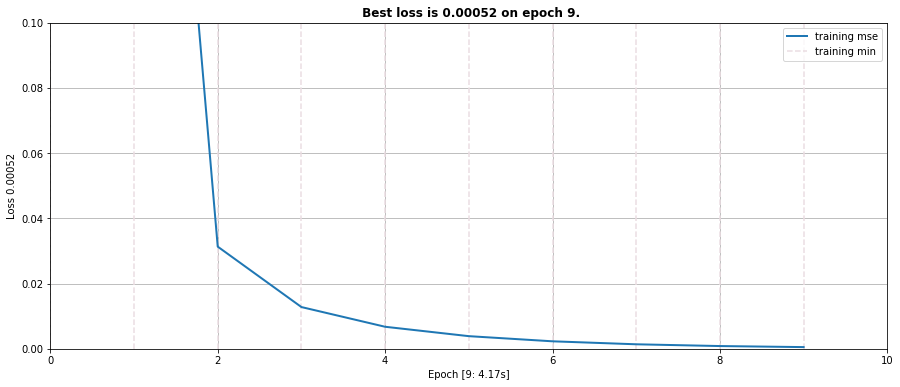

In [9]:
model_name = '../../models/lstm_stateful_1'

train_steps = nb_train_samples * seq_size // batch_size
valid_steps = nb_valid_samples * seq_size // batch_size

fit_params = {
    'train_steps':  train_steps,
    'opt':          Adam(),
    'loss':         'binary_crossentropy',
    'metrics':      ['accuracy'],
    'nepochs':      10, 
    'patience':     10,
    'ploss':        0.1,
    'reset':        True,
}

train_network(model, model_name, train_generator, **fit_params);


In [10]:
mean_acc = []
mean_loss = []
for i in range(valid_steps):
    x_b, y_b = next(valid_generator)
    loss, acc = model.test_on_batch(x_b, y_b)
    mean_acc.append(acc)
    mean_loss.append(loss)
    
print('validation accuracy = {}'.format(np.mean(mean_acc)))
print('               loss = {}'.format(np.mean(mean_loss)))


validation accuracy = 1.0
               loss = 0.000413906411267817
